In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import BPTTRNN as bp
import time
import seaborn as sns
import sklearn.svm
%load_ext autoreload
%autoreload 2

In [2]:
single_time_labels = ['0', 'A', '0', 'B', '0', 'C', '0', 'D', '0']
double_time_labels = []
double_time_labels_half = []
for stl in single_time_labels:
    double_time_labels.append(stl)
    double_time_labels.append(stl)
    double_time_labels_half.append(stl)
    double_time_labels_half.append('')
double_time_labels_blank = [x.replace('0', '') for x in double_time_labels]
assert len(double_time_labels_half) == len(double_time_labels)

## Create synthetic data
There are 8 possible values: 
- 0 $blank/0$
- 1 $A_1$
- 2 $A_2$
- 3 $B_1$
- 4 $B_2$
- 5 $C_1$
- 6 $C_2$
- 7 $D$

Data points are thus 8-dim vectors, with:

$z_{k, t} = (1_{0}, 1_{A_1}, 1_{A_2}, ... , 1_{D})$

where $k$ is the trial index, and $t$ is the trial time. Hence $|z_{k, t}| = 1 $ before white noise is added. Trials will be either $T=9$ data points long (single), and of form:

$ 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 $

or of length $T=18$ (double), and of form:

$ 0, 0, A_{\alpha}, A_{\alpha}, 0, 0, B_{\alpha}, B_{\alpha}, 0, 0, C_{\beta}, C_{\beta}, 0, 0, D, D, 0, 0 $

where $\alpha, \beta \in (1, 2)$, although one can use shorter sequences for testing (e.g. $0, A_{\alpha}, 0, B_{\alpha}, 0$). The expected sequence is $\alpha = \beta$, and the unexpected sequence is $\alpha \neq \beta$.

Network input $x_k = z_{k, 0:T-1}$ and output $y_k = z_{k, 1:T}$. 

In [3]:
d_dict = {  # data parameters dictionary
        'n_total': 1000,  # total number of data sequences
        'n_freq': 8,  # blank through D
        'n_times': 9,
        'doublesse': True,
        'ratio_train': 0.8,
        'ratio_exp': 0.75,  # probabilities of switching between alpha nd beta
        'noise_scale': 0.1
        }
if d_dict['doublesse']:
    eval_times = np.arange(4, 17)  # double
    d_dict['sequence'] = np.array(double_time_labels)
elif d_dict['doublesse'] is False:
    eval_times = np.arange(1, 8)  # single
    d_dict['sequence'] = np.array(single_time_labels)
t_dict = {'eval_times': eval_times}  # training paramter dictionary

freq_labels = ['0', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D']
tmp0, tmp1 = bp.generate_synt_data(n_total=d_dict['n_total'], 
                                   n_times=d_dict['n_times'], 
                                   n_freq=d_dict['n_freq'],
                                   ratio_train=d_dict['ratio_train'], 
                                   ratio_exp=d_dict['ratio_exp'], 
                                   noise_scale=d_dict['noise_scale'], 
                                   double_length=d_dict['doublesse'])
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

## RNN Model with BPTT

#### RNN model:

$(x_t, s_{t-1}) \to s_t \to \hat{y}_t == y_t = x_{t+1} $

within one trial $k$. 
Equations:

$s_t = \tanh( U \cdot x_t + W \cdot s_{t-1})$


$\hat{y}_t = softmax(V \cdot s_t) = \left( \frac{e^{V_i \cdot s_t}}{\sum_i e^{V_i \cdot s_t}} \right), \; for \; i \in (0, A_1, A_2 ... D)$

where $U_{n x f}, W_{n x n}, V_{f x n}$ are matrices where $n$ is the number of RNN nodes and $f$ the number of input/output frequencies.

#### Training procedure:

The full sequence $x_k$ is forwarded through the model, yielding $\hat{y}_k$. This is used to compute the loss function $L$, which error is backpropagated through time (BPTT) to the parameters $\theta = (U, W, V)$ (updated with SGD probably). 
The loss function $L$ uses cross entropy and L1 regularisation:

$L_k = \sum_{\tau} - y_{k, \tau} \log \hat{y}_{k, \tau} + \lambda \cdot ||\theta||_1$

where $\tau$ defines the trial times that are taken into account for Loss computation. 

$ \begin{equation}
    \tau =
    \begin{cases}
      (0, 1, 2, ... 8), & \text{all} \\
      (1, 3, 5, 7), & \text{non-blank (nb)}\\
      (3, 5, 7), & \text{non-initial nb (ninb)}
    \end{cases}
  \end{equation}$

#### Initial conditions:

Tricky.. Maybe start on each trials with either zero, or small-magnitude noise, for $s_{k, -1}$? The sequence $0, A_{\alpha}, 0$ then should provide a sensible initialisation, needed for $B_{\alpha}$ prediction... ?  


#### Pseudo-algorithm:

    for $it$ in epochs:
        for $k$ in trials:
            for $t$ in times:
                rnn.forward($x_t$)
            compute loss $L_k$
            update parameters with BPTT


In [4]:
## Set training parameters:
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
if d_dict['doublesse']:
    t_dict['learning_rate'] = 0.01
elif d_dict['doublesse'] is False:
    t_dict['learning_rate'] = 0.05
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 100
t_dict['l1_param'] = 5e-4  # L1 regularisation in loss function
t_dict['check_conv'] = False
t_dict['conv_rel_tol'] = 5e-4  # terminate training if relative difference between two epochs is smaller than this 


In [25]:
## Initiate RNN model
rnn = bp.RNN(n_stim=d_dict['n_freq'], n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [33]:
## Train with BPTT
rnn = bp.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

Epoch 8/100. Train loss: 0.702508:   8%|▊         | 8/100 [00:41<07:53,  5.15s/it]       

Training ended prematurely by user at epoch 8.


(60, 80)

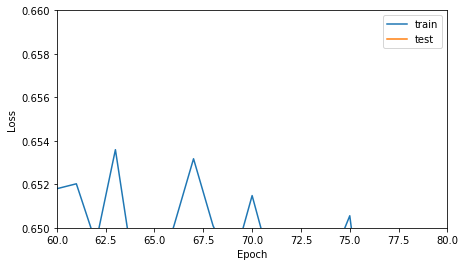

In [8]:
plt.rcParams['figure.figsize'] = (7, 4)
plt.plot(train_loss_arr, label='train')
plt.plot(test_loss_arr, label='test')
plt.xlabel('Epoch'); plt.ylabel("Loss"); plt.legend();
plt.ylim([0.65, 0.66])
plt.xlim([60, 80])

Trial type: 22


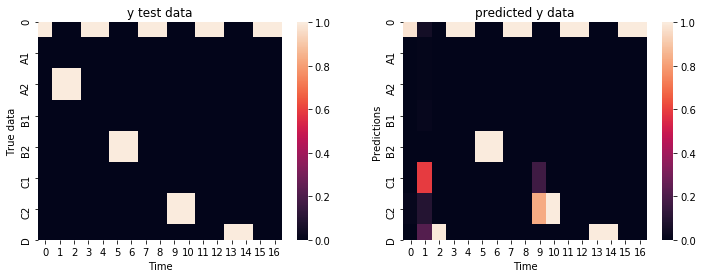

In [9]:
k = 0
print(f'Trial type: {labels_test[k]}')
pred = bp.compute_full_pred(x_test[k,:,:], model=rnn)
plt.rcParams['figure.figsize'] = (12, 4)

plt.subplot(121)
sns.heatmap(y_test[k, :, :].numpy().T, yticklabels=freq_labels)
plt.title("y test data"); plt.xlabel('Time'); plt.ylabel('True data')

plt.subplot(122)
sns.heatmap(pred.mean(0).detach().numpy().T, vmax=1, vmin=0, yticklabels=freq_labels)
plt.title("predicted y data"); plt.xlabel('Time'); plt.ylabel("Predictions");

Text(0.5, 24.0, 'Output')

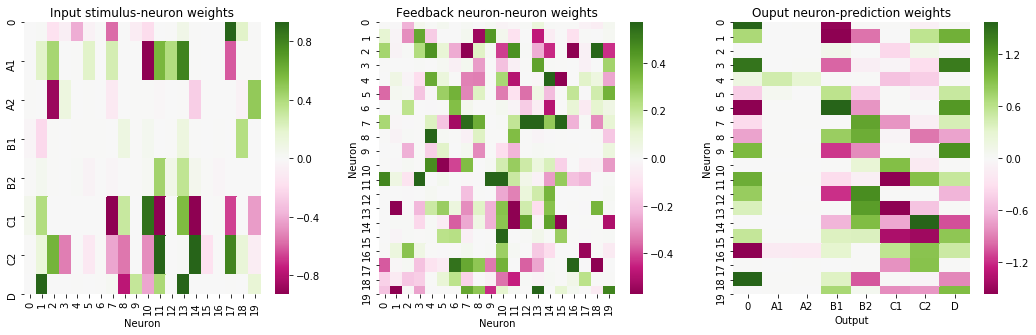

In [10]:
plt.rcParams['figure.figsize'] = (18, 5)

def plot_weights(ax, rnn_layer, title='weights'):
    weights = [x for x in rnn_layer.parameters()][0].detach().numpy().T
    cutoff = np.percentile(np.abs(weights), 95)
    sns.heatmap(weights, ax=ax, cmap='PiYG', vmax=cutoff, vmin=-1 * cutoff)
    ax.set_title(title); 
    return ax

fig, ax_w = plt.subplots(1, 3)
plot_weights(ax=ax_w[0], rnn_layer=rnn.lin_input,
            title='Input stimulus-neuron weights')
ax_w[0].set_yticklabels(freq_labels)
ax_w[0].set_xlabel('Neuron'); ax_w[1].set_ylabel('Stimulus')

plot_weights(ax=ax_w[1], rnn_layer=rnn.lin_feedback,
            title='Feedback neuron-neuron weights')
ax_w[1].set_xlabel('Neuron'); ax_w[1].set_ylabel('Neuron')

plot_weights(ax=ax_w[2], rnn_layer=rnn.lin_output,
            title='Ouput neuron-prediction weights')
ax_w[2].set_xticklabels(freq_labels)
ax_w[2].set_ylabel('Neuron'); ax_w[2].set_xlabel('Output')


## Cross temporal decoding

Each sequence $seq_k$ has labels $\alpha, \beta$. We wish to decode $\alpha$ dynamically per time point, in a cross-temporal manner, from the RNN hidden state $s_t$. Id est, we will create a decoder $dec(t | \tau) = P(\alpha = 1 | \tau)_t$ that is trained at time $\tau$ but evaluated at time $t$. We can choose to train our decoder with either or both $(\alpha = \beta)$ and $(\alpha \neq \beta)$ sequences. To decode, we will use a linear SVM with L2 regularisation (from sklearn). 

#### Pseudocode

    forward run of all trials
    for $\tau$ in T:
        train P($\alpha$ | $\tau$)
        for t in T:
            evaluate P($\alpha$ | $\tau$)_t

In [11]:
forw_mat = {'train': np.zeros((x_train.shape[0], x_train.shape[1], n_nodes)),
            'test': np.zeros((x_test.shape[0], x_test.shape[1], n_nodes))}

rnn.eval()
with torch.no_grad():
    
    ## Forward runs:
    for kk in range(x_train.shape[0]):  # trial loop
        rnn.init_state()
        hidden_state = rnn.state  # init state
        for tau in range(x_train.shape[1]):  # time loop
            hidden_state, output = rnn.forward(inp=x_train[kk, tau, :], 
                                               rnn_state=hidden_state)  # propagate
            forw_mat['train'][kk, tau, :] = hidden_state.numpy()  # save hidden states
            
    for kk in range(x_test.shape[0]):  # trial loop
        rnn.init_state()
        hidden_state = rnn.state
        for tau in range(x_test.shape[1]):  # time loop
            hidden_state, output = rnn.forward(inp=x_test[kk, tau, :], 
                                               rnn_state=hidden_state)
            forw_mat['test'][kk, tau, :] = hidden_state.numpy()
    
    ## Train decoder
    alpha_labels = {'train': np.array([int(x[0]) for x in labels_train]), 
                    'test': np.array([int(x[0]) for x in labels_test])}
    score_mat = np.zeros((x_train.shape[1], x_train.shape[1]))  # T x T
    decoder_dict = {}  # save decoder per time 
    for tau in range(x_train.shape[1]):  # train time loop
        decoder_dict[tau] = sklearn.svm.LinearSVC(C=1e-2)  # define SVM
        decoder_dict[tau].fit(X=forw_mat['train'][:, tau, :], 
                              y=alpha_labels['train'])  # train SVM
        for tt in range(x_train.shape[1]):  # test time loop 
            score_mat[tau, tt] = decoder_dict[tau].score(X=forw_mat['test'][:, tt, :],
                                                         y=alpha_labels['test'])  # evaluate

NameError: name 'n_nodes' is not defined

In [ ]:
# score_mat[0, 5] = -10
plt.rcParams['figure.figsize'] = (6, 5)
ax_score = sns.heatmap(score_mat, cmap='viridis', xticklabels=double_time_labels_blank[:-1], 
            yticklabels=double_time_labels_blank[:-1])
bottom, top = ax_score.get_ylim()
ax_score.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Training time tau'); plt.xlabel('Testing time t')
plt.title('Cross temporal SVM score');

In [ ]:
angle_change = np.zeros(x_train.shape[1] - 1)
for tau in range(x_train.shape[1] - 1):
    angle_change[tau] = np.sum(np.abs(decoder_dict[tau].coef_ - decoder_dict[tau + 1].coef_))
    
plt.rcParams['figure.figsize'] = (5, 3)
f, ax_ac = plt.subplots(1, 1)
ax_ac.plot(angle_change, linewidth=3)
ax_ac.set_xlabel('Time t'); ax_ac.set_ylabel('L1 norm between t and (t + 1)')
ax_ac.set_title('Instanteous change in decoder')
ax_ac.set_xticks(np.arange(len(angle_change)));
ax_ac.set_xticklabels(double_time_labels_blank[:-2]);

In [ ]:
decoder_axes = np.zeros((decoder_dict[0].coef_.size, len(decoder_dict)))
for k, v in decoder_dict.items():
    decoder_axes[:, k] = v.coef_
cutoff_w = np.percentile(np.abs(decoder_axes), 95)
plt.rcParams['figure.figsize'] = (4, 6)
ax_dec_diag = plt.subplot(3, 1, 1)
ax_dec_diag.plot(np.diag(score_mat), linewidth=3)
ax_dec_diag.set_ylabel('Score')
ax_dec_diag.set_title('Decoding performance (t = tau)')
ax_dec_diag.set_xticks(np.arange(len(np.diag(score_mat))));
ax_dec_diag.set_xticklabels(double_time_labels_blank[:-1]);
ax_dec_diag.set_xlim([-0.5, len(np.diag(score_mat)) - 0.5])
plt.subplot(3, 1, (2, 3))
ax_dec_w = sns.heatmap(decoder_axes, xticklabels=double_time_labels_blank[:-1],
                      vmin=-1 * cutoff_w, vmax=cutoff_w, cmap='PiYG', cbar=False)
bottom, top = ax_dec_w.get_ylim()
ax_dec_w.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Time t'); plt.ylabel('Neuron');

In [ ]:
plt.imshow(forw_mat['train'][12, :, :].T - forw_mat['train'][0, :, :].T, 
           vmax=0.75, vmin=-0.75, cmap='PiYG')
plt.colorbar()